Epoch 1/50


2024-10-16 15:43:05.703063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 2s 22ms/step - loss: 0.0906
Epoch 2/50
57/57 [==============================] - 1s 24ms/step - loss: 0.0410
Epoch 3/50
57/57 [==============================] - 1s 24ms/step - loss: 0.0382
Epoch 4/50
57/57 [==============================] - 1s 24ms/step - loss: 0.0381
Epoch 5/50
57/57 [==============================] - 1s 23ms/step - loss: 0.0368
Epoch 6/50
57/57 [==============================] - 1s 24ms/step - loss: 0.0360
Epoch 7/50
57/57 [==============================] - 1s 25ms/step - loss: 0.0348
Epoch 8/50
57/57 [==============================] - 1s 25ms/step - loss: 0.0347
Epoch 9/50
57/57 [==============================] - 1s 25ms/step - loss: 0.0348
Epoch 10/50
57/57 [==============================] - 1s 23ms/step - loss: 0.0346
Epoch 11/50
57/57 [==============================] - 1s 24ms/step - loss: 0.0345
Epoch 12/50
57/57 [==============================] - 1s 24ms/step - loss: 0.0336
Epoch 13/50
57/57 [=============================

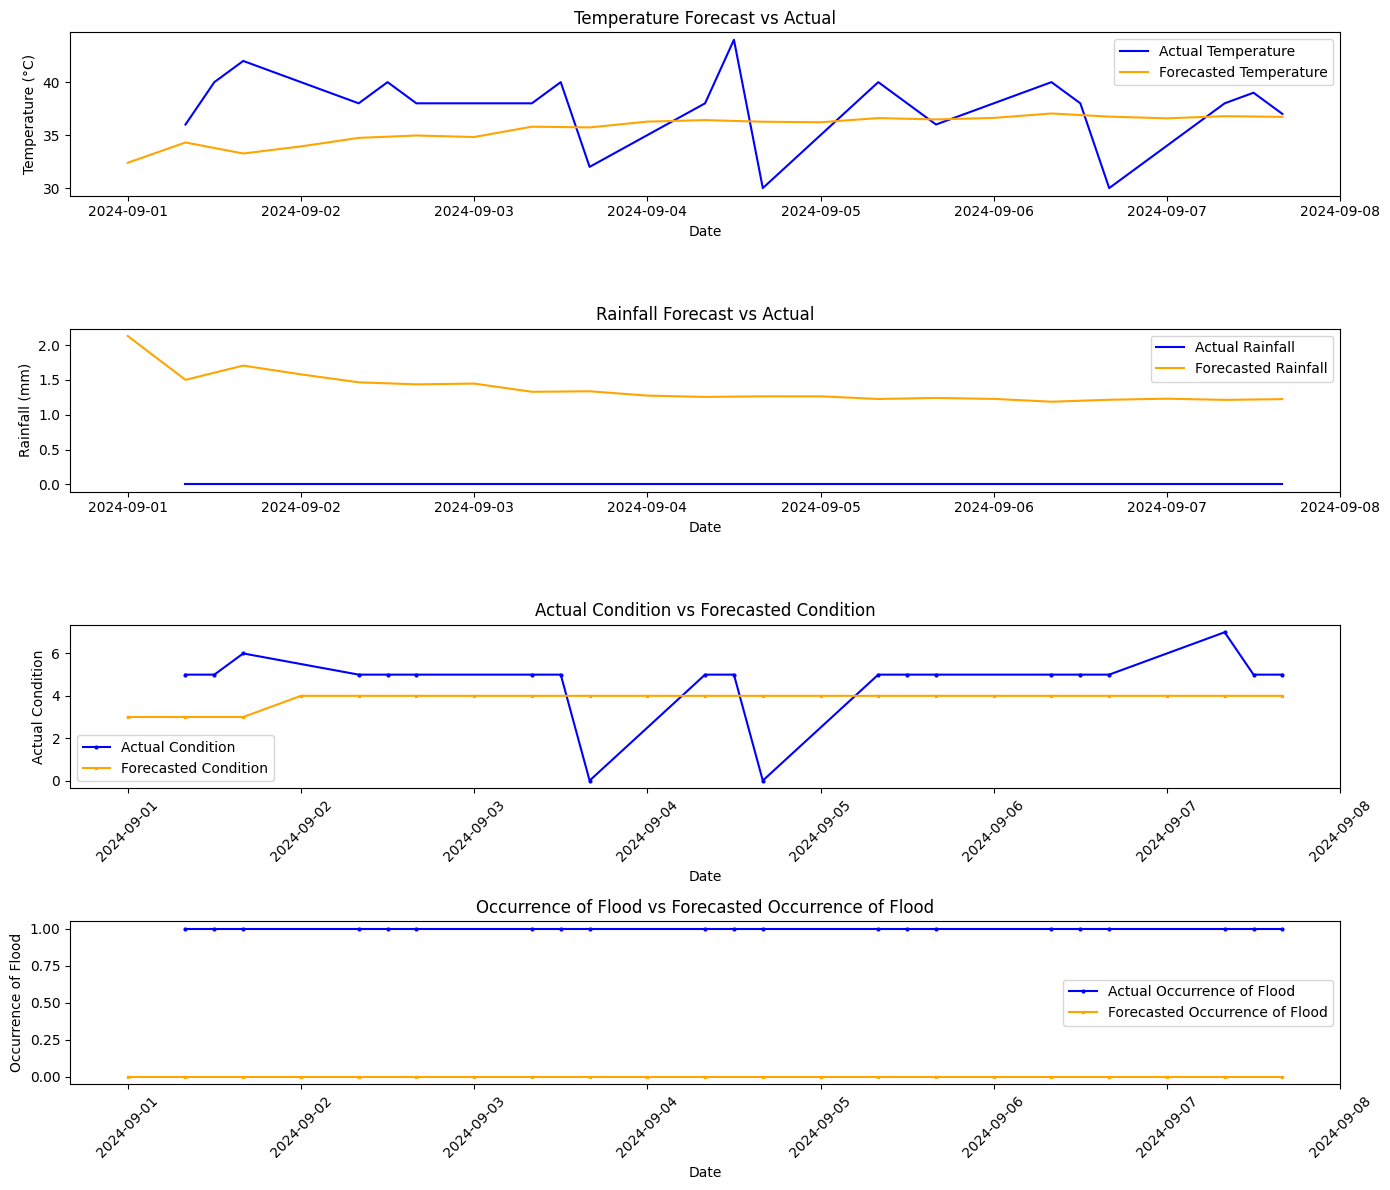

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator

# Load dataset
data = pd.read_csv('Cleaned_MCS_TEAM_DATA.csv')

# Convert 'DATETIME' to datetime object
data['DATETIME'] = pd.to_datetime(data['DATETIME'])

# Sort dataset by date
data = data.sort_values(by='DATETIME')

# Handle categorical data
# Encode 'ACTUAL CONDITION' and 'OCCURRENCE OF FLOOD'
le_condition = LabelEncoder()
le_flood = LabelEncoder()
data['ACTUAL CONDITION'] = le_condition.fit_transform(data['ACTUAL CONDITION'])
data['OCCURENCE OF FLOOD'] = le_flood.fit_transform(data['OCCURENCE OF FLOOD'])

# Features and target columns
features = ['TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION', 'OCCURENCE OF FLOOD']
target_columns = features

# Scale features to the range [0, 1]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# Prepare time series data
look_back = 21  # Number of time steps to look back (7 days * 3 readings/day)

# Create TimeseriesGenerator for training data
generator = TimeseriesGenerator(scaled_data, scaled_data, length=look_back, batch_size=32)

# Define the GRU Model
model = Sequential()
model.add(GRU(200, activation='relu', input_shape=(look_back, len(features)), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(features)))  # Output layer with multiple features

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(generator, epochs=50)

# Forecast the next 7 days (7 * 3 = 21 predictions)
n_future = 21  # Predicting 21 steps ahead (7 days of 3 readings per day)
last_data = scaled_data[-look_back:]  # Take the last 'look_back' period to predict

# Generate predictions for the next 7 days
forecast = []
input_seq = last_data.reshape((1, look_back, len(features)))

for _ in range(n_future):
    prediction = model.predict(input_seq)
    forecast.append(prediction[0])
    # Update the input sequence with the new prediction
    input_seq = np.append(input_seq[:, 1:, :], [[prediction[0]]], axis=1)

# Convert forecast back to original scale
forecast = scaler.inverse_transform(forecast)

# Create a DataFrame for the forecasted data
forecast_dates = pd.date_range(start=data['DATETIME'].max() + pd.Timedelta(hours=8), periods=n_future, freq='8H')
forecast_df = pd.DataFrame(forecast, columns=features)
forecast_df['DATETIME'] = forecast_dates

# Decode categorical values back to original form
forecast_df['ACTUAL CONDITION'] = le_condition.inverse_transform(forecast_df['ACTUAL CONDITION'].astype(int))
forecast_df['OCCURENCE OF FLOOD'] = le_flood.inverse_transform(forecast_df['OCCURENCE OF FLOOD'].astype(int))

# Load actual data for comparison
actual_data = pd.read_csv('Actual.csv')
actual_data['DATETIME'] = pd.to_datetime(actual_data['DATETIME'])

# Plotting the actual vs forecasted data
plt.figure(figsize=(14, 12))
print(forecast_df)
# Plot Temperature
plt.subplot(4, 1, 1)
plt.plot(actual_data['DATETIME'], actual_data['TEMPERATURE (°C)'], label='Actual Temperature', color='blue')
plt.plot(forecast_df['DATETIME'], forecast_df['TEMPERATURE (°C)'], label='Forecasted Temperature', color='orange')
plt.title('Temperature Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()

# Plot Rainfall
plt.subplot(4, 1, 2)
plt.plot(actual_data['DATETIME'], actual_data['RAINFALL (mm)'], label='Actual Rainfall', color='blue')
plt.plot(forecast_df['DATETIME'], forecast_df['RAINFALL (mm)'], label='Forecasted Rainfall', color='orange')
plt.title('Rainfall Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()

# Plot Actual Condition
plt.subplot(4, 1, 3)
plt.plot(actual_data['DATETIME'], actual_data['ACTUAL CONDITION'], label='Actual Condition', color='blue', marker='o', markersize=2)
plt.plot(forecast_df['DATETIME'], forecast_df['ACTUAL CONDITION'], label='Forecasted Condition', color='orange', marker='x', markersize=2)
plt.title('Actual Condition vs Forecasted Condition')
plt.xlabel('Date')
plt.ylabel('Actual Condition')
plt.xticks(rotation=45)
plt.legend()

# Plot Occurrence of Flood
plt.subplot(4, 1, 4)
plt.plot(actual_data['DATETIME'], actual_data['OCCURENCE OF FLOOD'], label='Actual Occurrence of Flood', color='blue', marker='o', markersize=2)
plt.plot(forecast_df['DATETIME'], forecast_df['OCCURENCE OF FLOOD'], label='Forecasted Occurrence of Flood', color='orange', marker='x', markersize=2)
plt.title('Occurrence of Flood vs Forecasted Occurrence of Flood')
plt.xlabel('Date')
plt.ylabel('Occurrence of Flood')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()
